In [1]:
from scipy import *
import WLanalysis
import cPickle as pickle
import camb
from camb import model, initialpower
from astropy.cosmology import FlatLambdaCDM
from scipy import optimize,stats
import os 
import numpy as np
import sys
import astropy.units as u
from scipy import interpolate
from scipy.integrate import quad
from IPython.display import Image
from matplotlib.patches import Ellipse
from astropy.io import fits

In [2]:
def plotEllipse(pos,P,edge,ls,ilabel,ax):
    '''plot the contour for covariance p
    where position is the center position
    p is the covariance [2,2] matirx'''
    U, s, Vh = svd(P) 
    orient = math.atan2(U[1,0],U[0,0])*180/pi
    ellipsePlot = Ellipse(xy=pos, width=2.0*math.sqrt(s[0]), 
                          height=2.0*math.sqrt(s[1]), angle=orient,edgecolor=edge, fill = 0, label=ilabel,ls=ls,linewidth=1.5)
    ax.add_patch(ellipsePlot)
    return ellipsePlot

In [48]:
z_source = arange(0.5,3,0.5)
fn_all = genfromtxt('cosmo_params_all.txt',usecols=1, dtype='string')
bad_fn = 'Om0.32526_As1.99963_mva0.10618_mvb0.10652_mvc0.11752_h0.70000_Ode0.66744'
fn_list =fn_all[fn_all!=bad_fn]

fidu_cosmo = fn_list[0]
ps_arr = array([[mean(load('ps_noisy_mat/%s/ALL_galXgal_%.1f_%.1f.npy'
                               %(icosmo,iz, iz)),axis=0) for icosmo in fn_list] for iz in z_source])
ps_fidu = array([load('ps_noisy_mat/cov/ALL_galXgal_%.1f_%.1f.npy'
                          %(iz, iz))[:10000]  for iz in z_source])
ps_fidu_uncorr = array([load('ps_noisy_mat/cov/ALL_galXgal_%.1f_%.1f.npy'
                                 %(iz,iz))[int(iz*2000):int( (iz+0.5)*2000)]  for iz in z_source])

In [15]:
params = genfromtxt('cosmo_params_all.txt',usecols=[2,3,4,5])[fn_all!=bad_fn] #M_nu Omega_m 10^9*A_s sigma_8

In [32]:
ell_edges = linspace(100,3000,21)
ell_fidu = WLanalysis.edge2center(ell_edges)
dell=ell_edges[1:]-ell_edges[:-1]

In [20]:
print ps_arr.shape, params.shape,ps_fidu.shape, ell.shape

(5, 100, 20) (100, 4) (5, 1000, 20) (20,)


In [21]:
ps_all = [WLanalysis.buildInterpolator(ps_arr[i], params[:,:-1]) for i in range(5)]

In [23]:
ds = pickle.load(open("pickled_derivatives_powers.pkl",'rb'))
dcldmnu_mat = array([ds['mnu'][i,i] for i in range(5)])
dcldmnu_mat.shape
ell_mat = arange(5000)

(5, 20)


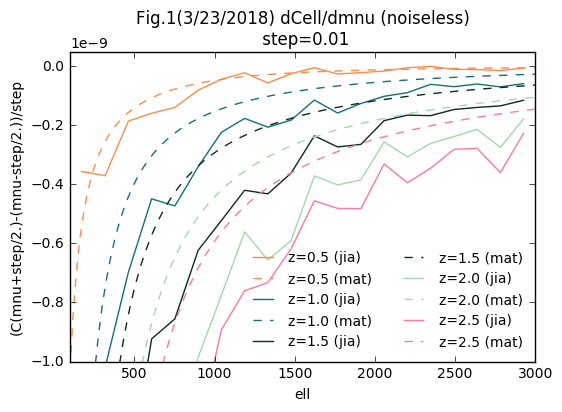

(5, 20)


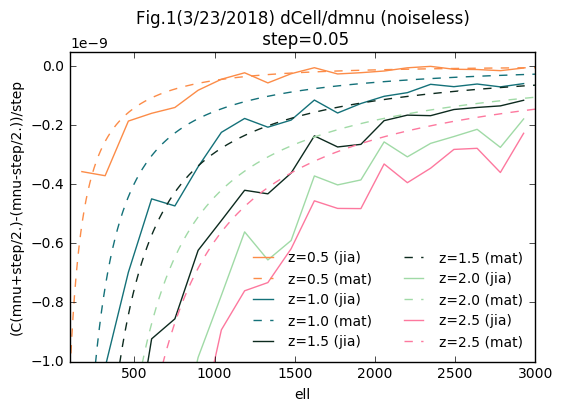

(5, 20)


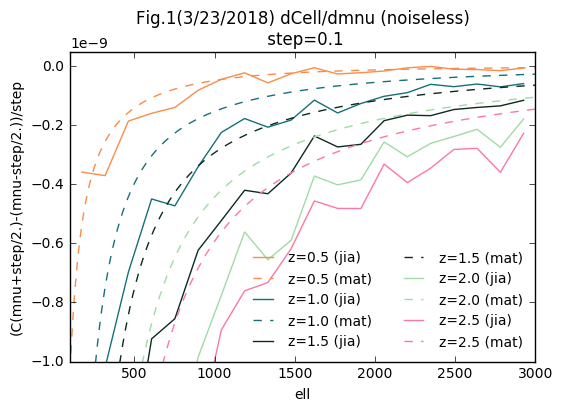

In [72]:
for istep in [0.01, 0.05, 0.1]:
    ps_hi = array ( [ps_all[i]( (0.1 * (1+istep/2), 0.3, 2.1))  for i in range(5)])
    ps_lo = array ( [ps_all[i]( (0.1 * (1-istep/2), 0.3, 2.1))  for i in range(5)])
    dcldmnu_jia = (ps_hi - ps_lo)/(0.1*istep)
    print dcldmnu_jia.shape

    f,ax=subplots(1,1,figsize=(6,4))
    seed(45)
    for i in range(5):
        icolor=rand(3)
        ax.plot(ell_fidu, dcldmnu_jia[i],'-',color=icolor,label='z=%s (jia)'%(z_source[i]))
        ax.plot(ell_mat, dcldmnu_mat[i],'--',color=icolor,label='z=%s (mat)'%(z_source[i]))

    ax.set_xlim(100,3000)
    ax.set_ylim(-1e-9,0.5e-10)
    ax.legend(loc=0,frameon=0,fontsize=10,ncol=2)
    ax.set_xlabel('ell')
    ax.set_ylabel('(C(mnu+step/2.)-(mnu-step/2.))/step')
    ax.set_title('Fig.1(3/23/2018) dCell/dmnu (noiseless)\n step=%s'%(istep))
    show()

In [80]:
istep = 0.1
ps_hi = array ( [ps_all[i]( (0.1 * (1+istep/2), 0.3, 2.1))  for i in range(5)])
ps_lo = array ( [ps_all[i]( (0.1 * (1-istep/2), 0.3, 2.1))  for i in range(5)])
dcldmnu_jia = (ps_hi - ps_lo)/(0.1*istep)

ps_omhi = array ( [ps_all[i]( (0.1 , 0.3* (1+istep/2), 2.1))  for i in range(5)])
ps_omlo = array ( [ps_all[i]( (0.1 , 0.3* (1-istep/2), 2.1))  for i in range(5)])
dcldom_jia = (ps_omhi - ps_omlo)/(0.3*istep)

ps_Ashi = array ( [ps_all[i]( (0.1 , 0.3, 2.1* (1+istep/2)))  for i in range(5)])
ps_Aslo = array ( [ps_all[i]( (0.1 , 0.3, 2.1* (1-istep/2)))  for i in range(5)])
dcldAs_jia = (ps_Ashi - ps_Aslo)/(2.1*istep)

In [74]:
print iCl.shape, iCov.shape, ps_arr.shape, ps_fidu.shape

(20,) (20, 20) (5, 100, 20) (5, 10000, 20)


In [75]:
ngal_arr = array([8.83154075745,13.2459963296,11.1471697714,7.3641882868,4.26106360488])
Clnn =  array([0.35**2 / ngal / 1.18e7 for ngal in ngal_arr])

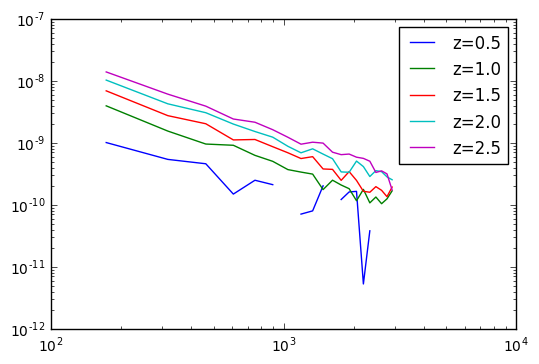

In [95]:
for i in range(5):
    loglog(ell_fidu, mean(ps_arr[i],axis=0),label='z=%.1f'%(z_source[i]))
legend()
show()

ERROR! Session/line number was not unique in database. History logging moved to new session 1364


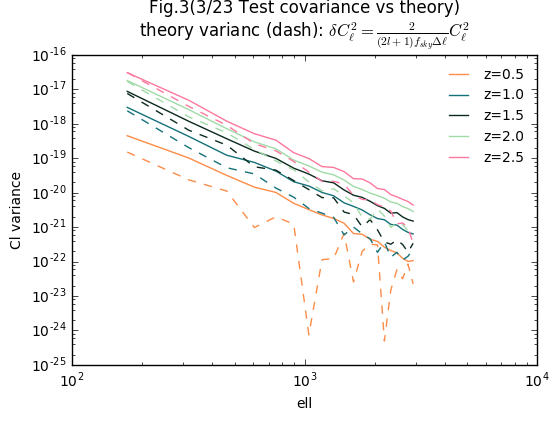

In [93]:
fsim = 3.5**2/4e4
seed(45)
th_label = r'theory varianc (dash): $\delta C_\ell^2=\frac{2}{(2l+1)f_{sky}\Delta\ell}C_\ell^2$'
for i in range(5):
    icolor=rand(3)
    iCl = mean(ps_fidu[i],axis=0)
    iCov = cov(ps_fidu[i],rowvar=0) 
    
    loglog(ell_fidu, diag(iCov),'-',color=icolor,label='z=%.1f'%(z_source[i]))
    loglog(ell_fidu, 2/((2*ell_fidu+1)*dell*fsim)*iCl**2, '--', color=icolor)
title('Fig.3(3/23 Test covariance vs theory)\n'+th_label)
xlabel('ell')
ylabel('Cl variance')
legend(fontsize=10,loc=0,frameon=0)
show()

In [78]:
ps_fidu.shape

(5, 10000, 20)

Fisher test 5 redsfhits, fky= 0.5
    (1) [ 0.00643857  0.00113153  0.01767495]: Jia Method, using only self variance
    (2) [ 0.00646654  0.00113379  0.01771283]: Jia Method, using self & cross variance
    (3) [ 0.00736579  0.00150651  0.02149756]: Jia Method, Using full covariance
    


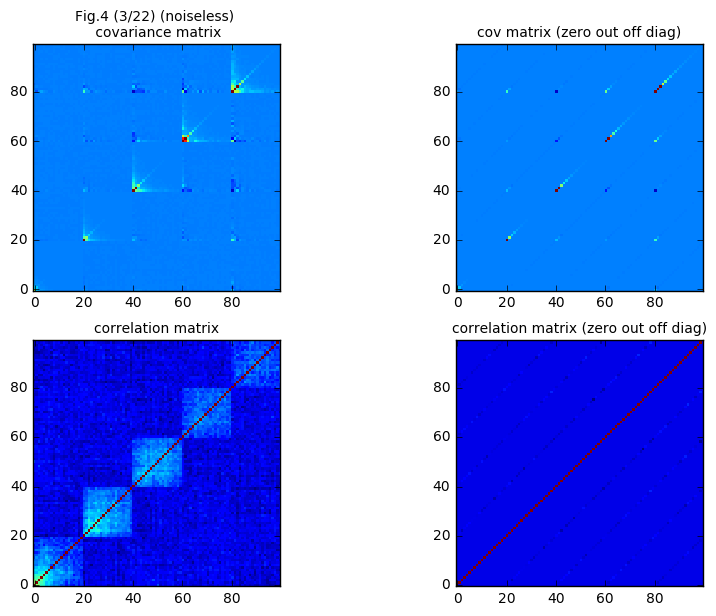

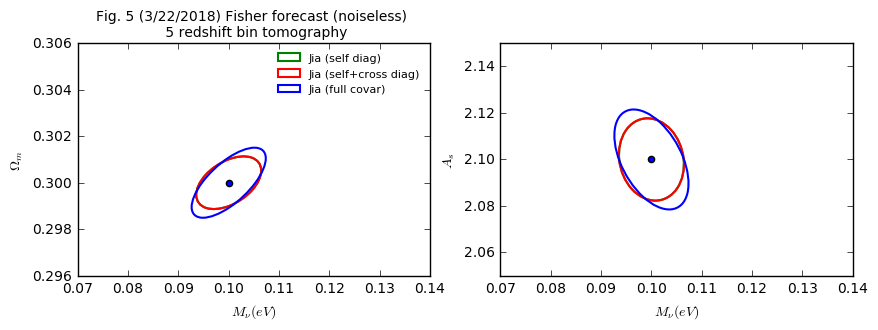

Fisher test 5 redsfhits, fky= 0.5
    (1) [ 0.00645015  0.00113095  0.01763048]: Jia Method, using only self variance
    (2) [ 0.00607625  0.00103989  0.01599749]: Jia Method, using self & cross variance
    (3) [ 0.00686136  0.00140697  0.01935438]: Jia Method, Using full covariance
    


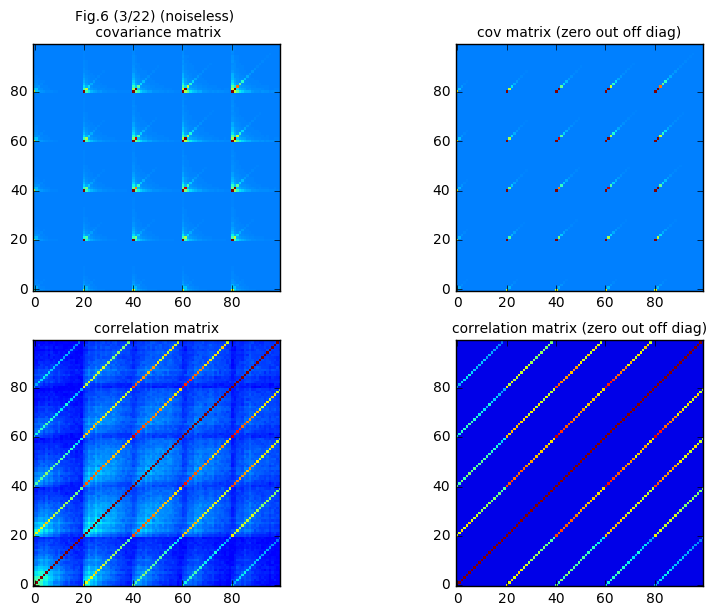

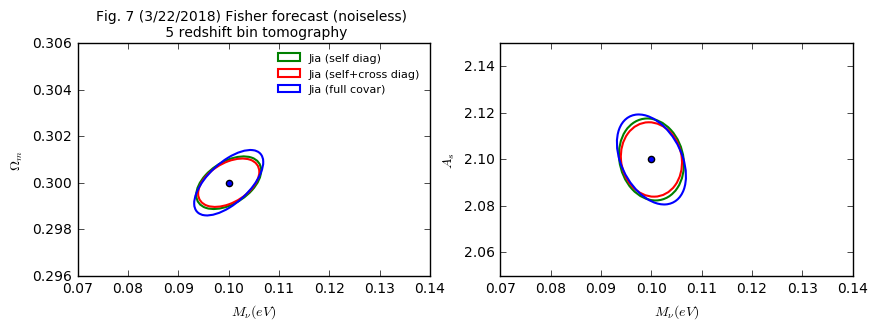

In [82]:
###### now use mat's calculation
copyarray = lambda x, times: repeat(x.reshape(1,-1),times,axis=0).flatten()
Ferr = lambda Fisher_mat: real(sqrt(mat(Fisher_mat).I)[[0,1,2],[0,1,2]]) 
Ferr_diag = lambda Fisher_mat: real(1/sqrt(diag(Fisher_mat)))
Nl = 20
ifig=4
dd5_arr = [dcldmnu_jia, dcldom_jia, dcldAs_jia]

for ips in [ps_fidu_uncorr, ps_fidu,]:
    Nr = ips.shape[1] # number of realizations
    Cl5 = ps_arr
    Cl5f = Cl5.flatten()
    dd5_flat = [idd.flatten() for idd in dd5_arr] ## flatten the derivative array
    ps2 = swapaxes(ips,0,1)
    Cov5 = cov(ps2.reshape(Nr,-1) ,rowvar=0)

    ## (1) zero out the off diagonal components
    ## (1b) zero out off diag, use theory variance
    Cov5_diag = zeros(shape=Cov5.shape)
    Cov5_diag1 = zeros(shape=Cov5.shape)
    Cov5_diag1[diag_indices(Nl*5)] = Cov5 [diag_indices(Nl*5)]

    for j in arange(5):
        for k in arange(5):
            for i in arange(Nl):
                Cov5_diag [j*Nl+i,k*Nl+i] = Cov5[j*Nl+i,k*Nl+i]
                #Cov5_diagT[j*Nl+i,k*Nl+i] = 2/((2*ellF[i]+1)*fsim*dell[i])*Cl5[j,i]*Cl5[k,i]

    ## (2) inverse covariance matrix
    Cov5I = mat(Cov5).I
    Cov5diagI = mat(Cov5_diag).I
    Cov5diag1I = mat(Cov5_diag1).I

    ## (3) Fisher matrices
    F_jiadiag = zeros(shape=(3,3))
    F_jiadiag1 = zeros(shape=(3,3))
    F_jiafull = zeros(shape=(3,3))
    F_mat_cross = zeros(shape=(3,3))
    for i in range(3):
        for j in range(3):
            dA, dAf = dd5_arr[i], dd5_flat[i]
            dB, dBf = dd5_arr[j], dd5_flat[j]
            Mij = mat(dAf).T*mat(dBf) + mat(dBf).T*mat(dAf)  
            F_jiadiag [i,j]= 0.5*trace(Cov5diagI*Mij)
            F_jiadiag1 [i,j]= 0.5*trace(Cov5diag1I*Mij)
            F_jiafull [i,j]= 0.5*trace(Cov5I* Mij)        

    Flist5 = array( [ F_jiadiag1, F_jiadiag, F_jiafull]) / (12.5/2e4)
    Ferr5_out = ([Ferr(imat) for imat in Flist5])
    print '''Fisher test 5 redsfhits, fky= 0.5
    (1) %s: Jia Method, using only self variance
    (2) %s: Jia Method, using self & cross variance
    (3) %s: Jia Method, Using full covariance
    '''% (Ferr5_out[0], Ferr5_out[1], Ferr5_out[2])

    ##############
    f, ((ax1,ax2),(ax1b,ax2b))=subplots(2,2,figsize=(10,7))
    istd=std(Cov5)
    ax1.imshow(Cov5,origin='lower', vmin=-istd, vmax=3*istd, interpolation='nearest')
    ax1.set_title('Fig.%i (3/22) (noiseless) \n covariance matrix'%(ifig), fontsize=10)
    ax2.imshow(Cov5_diag,origin='lower', vmin=-istd, vmax=3*istd, interpolation='nearest')
    ax2.set_title('cov matrix (zero out off diag)', fontsize=10)

    ax1b.imshow(WLanalysis.corr_mat(Cov5),origin='lower', interpolation='nearest',vmin=-0.1, vmax=1)
    ax1b.set_title('correlation matrix', fontsize=10)
    ax2b.imshow(WLanalysis.corr_mat(Cov5_diag),origin='lower', interpolation='nearest',vmin=-0.1, vmax=1)
    ax2b.set_title('correlation matrix (zero out off diag)', fontsize=10)
    show()
    
    ##############
    f, (ax1,ax2) = subplots(1,2,figsize=(10,3))
    ax1.scatter(0.1, 0.3)
    ax2.scatter(0.1, 2.1)

    jjj=0
    labels=['Jia (self diag)', 'Jia (self+cross diag)', 'Jia (full covar)']
    for iF in Flist5:
        icolor=['g','r','b','orange','purple','k'][jjj]
        ilabel=labels[jjj]
        plotEllipse([0.1, 0.3], mat(iF).I[[0,1],:][:,[0,1]] ,icolor,'solid',ilabel,ax1)
        plotEllipse([0.1, 2.1], mat(iF).I[[0,2],:][:,[0,2]] ,icolor,'solid',ilabel,ax2)
        jjj+=1
    ax1.set_xlim(0.07,0.14)
    ax1.set_ylim(0.296,0.306)
    ax2.set_xlim(0.07,0.14)
    ax2.set_ylim(2.05,2.15)
    ax1.set_xlabel(r'$M_\nu(eV)$')
    ax1.set_ylabel(r'$\Omega_m$')
    ax2.set_xlabel(r'$M_\nu(eV)$')
    ax2.set_ylabel(r'$A_s$')
    ax1.legend(fontsize=8,frameon=0,ncol=1)
    ax1.set_title('Fig. %i (3/22/2018) Fisher forecast (noiseless) \n 5 redshift bin tomography'%(ifig+1),fontsize=10)
    show()
    
    ifig+=2